# Loading Met Office real time model data

In [1]:
import intake
import iris
import iris.experimental.equalise_cubes
import jade_utils.human_tools
import jade_utils.iris_tools

import matplotlib.pyplot as plt
import iris.quickplot as qplt

/opt/conda/lib/python3.6/site-packages/intake/source/discovery.py:39: UserWarning: Plugin name collision for "netcdf" from
    /opt/conda/lib/python3.6/site-packages/intake_iris/netcdf.py
and
    /opt/conda/lib/python3.6/site-packages/intake_xarray/netcdf.py
Keeping plugin from first location.
  % (plugin_name, orig_path, new_path))


# List the available datasets
On Pangeo we make common datasets available with a tool called intake. Intake has a concept of catalogs which can be read, each catalog will return data in a common container format (numpy, pandas, Iris, xarray, etc...). Let's have a look through the data we have built in.

In [2]:
# Show the intake gui for exploring datasets
intake.gui

Intake GUI instance: to get widget to display, you must install ipy/jupyter-widgets, run in a notebook and, in the case of jupyter-lab, install the jlab extension.

# Read the manifest

The Met Office makes real time model data available through an internal platform called Service Hub. On Pangeo we are caching the last 24 hours of data in AWS S3 and provide a manifest of the files as a dataset called `service_hub_manifest`. Let's read the manifest and have a look at a few entiries.

In [3]:
# Read the manifest from intake
manifest = intake.cat.service_hub_manifest.read()

# Show the head of the manifest so we can see what kind of metadata we have
manifest.head()

,cell_methods,created_time,forecast_period,forecast_period_bounds,forecast_period_units,forecast_reference_time,height,height_units,model,name,object_size,pressure,pressure_units,realization,time,ttl
key,,,,,,,,,,,,,,,,
00002049a5b7fc4667603169245baf474dfca74f.nc,NaN,2018-08-23T16:25:38Z,54000,NaN,seconds,2018-08-23T12:00:00Z,NaN,NaN,mo-atmospheric-mogreps-g-prd,air_pressure_at_sea_level,46021091,NaN,NaN,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17,NaN,1535137176
000079d6ab333e9d66dc1fcf09bbd2cba1995e52.nc,time: mean (interval: 1 hour),2018-08-24T07:15:10Z,25200,21600 25200,seconds,2018-08-24T06:00:00Z,NaN,NaN,mo-atmospheric-ukv-prd,thickness_of_rainfall_amount,1114471,NaN,NaN,NaN,NaN,1535181462
0000851f7203c55b1de3f1ea7e1f0e10956235a3.nc,NaN,2018-08-26T02:15:28Z,25200,NaN,seconds,2018-08-26T01:00:00Z,NaN,NaN,mo-atmospheric-ukv-prd,low_type_cloud_area_fraction,2186556,NaN,NaN,NaN,NaN,1535336273
000090d3c530ffa965c4e55e234bd61adacceb4d.nc,NaN,2018-08-27T21:47:17Z,50400,NaN,seconds,2018-08-27T18:00:00Z,NaN,NaN,mo-atmospheric-global-prd,high_type_cloud_area_fraction,2753704,NaN,NaN,NaN,NaN,1535494156
0000a466f42ee498985f5cbf038173512c28d1c1.nc,NaN,2018-08-24T04:25:54Z,25200,NaN,seconds,2018-08-24T03:00:00Z,NaN,NaN,mo-atmospheric-ukv-prd,lwe_thickness_of_surface_snow_amount,81850,NaN,NaN,NaN,NaN,1535171443


# What is in the manifest

The manifest can be very large and contains metadata for files which which were generated for a number of models. Each model produces fields of different environmental properties such as rian, wind, pressure, etc. This data is pretty big, let's calculate how much we have based on the size of each object.

In [5]:
# Show the cumulative file size in human readable format
jade_utils.human_tools.human_bytes(int(manifest['object_size'].sum()))

'37.4TiB'

In [15]:
# Get the number of files in the manifest
len(manifest)

606072

This is quite a lot of data to be working with, so let's filter our manifest down. We can start by having a look at what models are contained in this dataset.

In [6]:
# Get unique model names and show them in a list
list(manifest['model'].unique())

['mo-atmospheric-mogreps-g-prd',
 'mo-atmospheric-ukv-prd',
 'mo-atmospheric-global-prd',
 'mo-atmospheric-mogreps-uk-prd']

There are four models here, let's focus on a model called UKV which is a deterministic model covering the UK in high resultion. We can have a look at the different parameters available in this model.

In [7]:
# Get unique variable names and show them in a list
list(manifest[manifest['model'] == 'mo-atmospheric-ukv-prd']['name'].unique())

['thickness_of_rainfall_amount',
 'low_type_cloud_area_fraction',
 'lwe_thickness_of_surface_snow_amount',
 'soil_temperature',
 'relative_humidity',
 'cloud_volume_fraction_in_atmosphere_layer',
 'air_temperature',
 'wind_speed',
 'wet_bulb_potential_temperature',
 'deprecated_snowfall_fraction_of_precipitation_rate',
 'wet_bulb_freezing_level_height',
 'dew_point_temperature',
 'wind_speed_of_gust',
 'land_binary_mask',
 'net_downward_shortwave_flux_in_air',
 'surface_downwelling_shortwave_flux_in_air',
 'cloud_base_height_0p1_oktas',
 'cloud_base_height_2p5_oktas',
 'visibility_in_air',
 'medium_type_cloud_area_fraction',
 'cloud_base_altitude_assuming_only_consider_cloud_area_fraction_greater_than_4p5_oktas',
 'deprecated_precipitation_rate',
 'high_type_cloud_area_fraction',
 'freezing_level_height',
 'fog_area_fraction',
 'freezing_level_altitude',
 'lwe_snowfall_rate',
 'surface_altitude',
 'cloud_area_fraction',
 'cloud_base_altitude_assuming_only_consider_cloud_area_fraction_g

There are lots of different data types in here that we could explore, but in this instance we are most interested in rainfall. Let's extract a subset of the manifest which contains rainfall data from the UKV model.

In [8]:
# Filter the full manifest by model and variable
ukv_rainfall_manifest = manifest[(manifest['model'] == 'mo-atmospheric-ukv-prd') & (manifest['name'] == 'thickness_of_rainfall_amount')]

# Show the length of the manifest
len(ukv_rainfall_manifest)

4740

Calling `len()` on the manifest shows there are 4730 files containing rainfall from the UKV model currently available on S3. We are probably only interested in the most recent data, the model we generated 24 hours ago is going to be less useful than the one we generated one hour ago. The most recent model run is probably still being uploaded to S3 so let's filter our list to the one before that.

In [11]:
# Get the latest complete forecast model by sorting in date order and take the penultimate one (because the latest one is likely incomplete)
[_, _, latest_frt, *_] = sorted(ukv_rainfall_manifest['forecast_reference_time'].unique(), reverse=True)

# Get a manifest of files for that model run time
latest_run_manifest = ukv_rainfall_manifest[ukv_rainfall_manifest['forecast_reference_time'] == latest_frt]

# Show the length of the manifest
len(latest_run_manifest)

54

This model run consists of 54 files containing rainfall for the UK.

# Loading with iris
At the Met Office we use a tool called iris to load and analyse gridded model data. We need to load the files from S3 using the `/s3` mount point and merge them together into a continuous cube of data. Each file will contain a number of time points from the run, so we need to slice them over time and then merge into a continuous axis.

In [12]:
# Generate a list of paths from the manifest
files = ['/s3/informatics-aws-earth-staging/{}'.format(key) for key in list(latest_run_manifest.index)]

# Load the files into a list of cubes
cubelist = iris.load(files)

# Iris is vert strict about metadata, so we first need to tell it to sync up the attributes before merging
iris.experimental.equalise_cubes.equalise_attributes(cubelist)

# We need to tease the timesteps in each file apart and then put them back together into a continuous time series
timesteps = iris.cube.CubeList([])
for c in cubelist:
    for t in c.slices_over("time"):
        timesteps.append(t)
[cube] = timesteps.merge()

# Now we have a cube we can have a look at it
cube

<iris 'Cube' of thickness_of_rainfall_amount / (m) (time: 54; projection_y_coordinate: 970; projection_x_coordinate: 1042)>

## Plotting

Now that we have a cube of data we can plot it. Let's start with the first timestep.

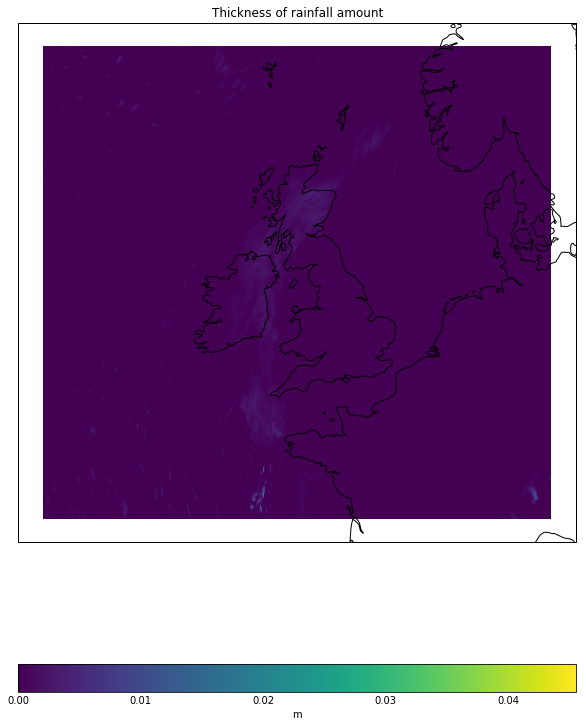

In [13]:
# Create a new matplotlib figure
fig = plt.figure(figsize=(10, 15))

# Plot the data using pcolormesh
qplt.pcolormesh(cube[0])

# Add coastlines to the map
plt.gca().coastlines('50m')

# Display it
plt.show()